In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from molfeat.trans import FPVecTransformer
from molfeat.trans.pretrained import PretrainedHFTransformer
import matplotlib.pyplot as plt

from utils import *

import os
# disabling parallelism to avoid deadlock
os.environ["TOKENIZERS_PARALLELISM"] = "false"

#### Configuration file
- model: Contains the list of models (here, Logistic Regression and Random Forest) along with their respective hyperparameter grids.
- featuerizers: Lists the featurizers used for transforming SMILES into features, here including a pretrained GPT transformer and a molecular fingerprint vectorizer.
- n_folds: Specifies the number of folds for both validation and testing (set to 5 for this project).
- active_threshold: The threshold for defining active compounds, set to 8 in this project.

In [2]:
config = {
    'model':
        [
            {
                'name': 'LR',
                'clf': LogisticRegression(solver='liblinear'),
                'h_params': {
                    'C': [1e2, 1e1, 1e0, 1e-1, 1e-2],
                }
            },
            {
                'name': 'RF',
                'clf': RandomForestClassifier(criterion='entropy'),
                'h_params': {
                    'n_estimators': [50, 100, 200],
                    'max_depth': [10, 20, 30]
                }
            }
        ]
    ,
    'featuerizers':
        [
            {
                'name': 'GPT',
                'transformer': PretrainedHFTransformer(kind='GPT2-Zinc480M-87M', notation='smiles', dtype=np.float32)
            },
            {
                'name': 'secfp',
                'transformer': FPVecTransformer(kind='secfp', dtype=np.float32)
            }
        ],
    'n_folds': {
        'val': 5,
        'test': 5
    },
    'active_threshold': 8
}


In [3]:
# load data into a dataframe
df = get_data('data.csv', active_threshold=config['active_threshold'])

/Users/sorawitsaengkyongam/venvs/sorawit_udg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Batch compute::   0%|          | 0/19 [00:00<?, ?it/s]

/Users/sorawitsaengkyongam/venvs/sorawit_udg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Batch compute::   0%|          | 0/19 [00:00<?, ?it/s]

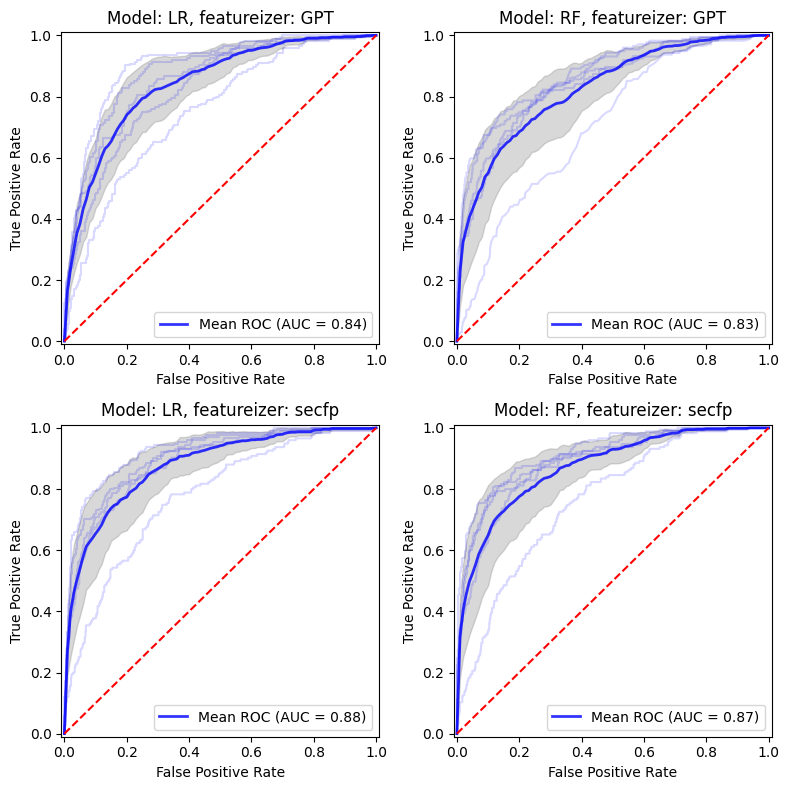

In [4]:
# get the number of models and featurizers from the config
n_model = len(config['model'])
n_feat = len(config['featuerizers'])

# initialize subplots
fig, axarr = plt.subplots(n_feat, n_model, figsize=(n_feat * 4, n_model * 4))

# train the model for each combination of featurizers and classifiers defined in the config
for i, featurizer in enumerate(config['featuerizers']):
    # obtain the feature representations and labels
    X, y = prepare_data(df, featurizer['transformer'])
    for j, model in enumerate(config['model']):
        # train the model with hyperparameters tuning using k-fold cross-validation and plot the corresponding ROC curve
        get_model_performance(model, X, y, featurizer['name'], axarr[i, j], config)
        
plt.tight_layout()
plt.show()

### Based on the above plots, it appears that the SECFP fingerprint vectorizer outperforms the pre-trained model features for this dataset. Specifically, combining the SECFP featurizer with logistic regression offers the best performance, achieving an AUC of 0.88. In practical applications, one can use the resulting ROC curve to select an optimal probability threshold to balance the trade-off between false positive and true positive rates according to real-world constraints.